In [1]:
import requests
from bs4 import BeautifulSoup
from io import StringIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram

plt.style.use('default')

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

In [2]:
# url = 'https://www.isyatirim.com.tr/tr-tr/analiz/hisse/Sayfalar/Temel-Degerler-Ve-Oranlar.aspx?endeks=03#page-1'
url = 'https://www.isyatirim.com.tr/en-us/analysis/stocks/Pages/bist-data-table.aspx?endeks=03#page-1'
r = requests.get(url)
s = BeautifulSoup(r.text, 'html.parser')

In [3]:
table = s.find('table', {'id':'summaryBasicData'})
table = StringIO(str(table))

table = pd.read_html(table, flavor='bs4')[0]
display(table.head(3))

,Stock,Name,Sector,Close (TL),Market Cap (mn TL),Market Cap (mn $),Float Rate (%),Paid In Capital (mn TL)
0,AKBNK,Akbank,Bankacılık,5720,"297.440,0","8.682,7",529,"5.200,0"
1,ALARK,Alarko Holding,Holdingler,8635,"37.562,3","1.096,5",371,4350
2,ASELS,Aselsan,Savunma,5875,"267.900,0","7.820,4",258,"4.560,0"


In [4]:
shares = table['Stock'].to_list()

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

English version is not available
```
https://www.isyatirim.com.tr/_layouts/15/Isyatirim.Website/Common/Data.aspx/HisseTekil?hisse=ADEL&startdate=01-09-2022&enddate=27-09-2024
```

In [5]:
_url = 'https://www.isyatirim.com.tr/_layouts/15/Isyatirim.Website/Common/Data.aspx/HisseTekil?'
data = []

for share in shares:
    params = {
        'hisse':share,
        'startdate': '01-09-2022',
        'enddate': '20-09-2024'
    }
    
    _r = requests.get(_url, params=params).json()['value']
    temp = pd.DataFrame.from_dict(_r)
    try: 
        temp = temp.iloc[:,1:3]      # Date & Adjusted Closing Price
        temp.columns = ['Date', params['hisse']]
        data.append(temp)
    except ValueError:
        print('ValueError for', share)

In [6]:
df = data[0]
for share in data[1:]:
    df = df.merge(share, on='Date', how='outer')

df.drop(columns='Date', inplace=True)
del(data)

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

In [7]:
data = pd.DataFrame()
data['Return'] = df.pct_change(fill_method=None).mean()*252               # working days
data['Volatility'] = df.pct_change(fill_method=None).std() * np.sqrt(252)
data.head(3)
# del(df)

,Return,Volatility
AKBNK,131.149402,19.694032
ALARK,27.795493,8.057247
ASELS,72.013974,13.493580


<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p> 

**In case there is an outlier value, if we want to remove this value**

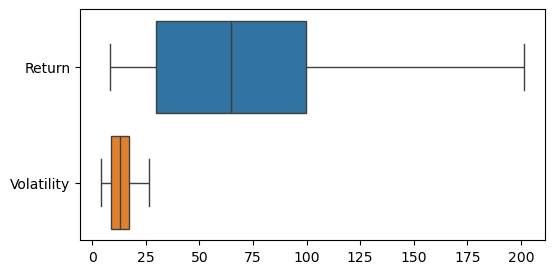

In [8]:
sns.boxplot(data,orient='h')
plt.gcf().set_size_inches(6,3)
plt.show()

In [9]:
display(
    data.nlargest(1, columns='Return'),
    data.nlargest(1, columns='Volatility')
)

,Return,Volatility
ULKER,201.30636,26.557903


,Return,Volatility
ULKER,201.30636,26.557903


In [10]:
# index = data.nlargest(1, columns='Return').index
data.drop(index='ULKER', inplace=True) # Outlier

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

In [11]:
X = data.copy()
mms = MinMaxScaler()
X = mms.fit_transform(X)
X = pd.DataFrame(X, columns=data.columns)
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Return,29.0,0.440164,0.306730,0.0,0.154591,0.432354,0.643795,1.0
Volatility,29.0,0.531413,0.311631,0.0,0.255073,0.555570,0.813151,1.0


<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

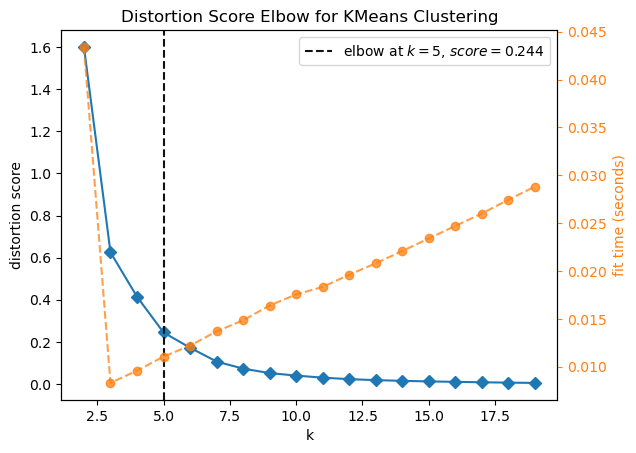

In [12]:
model_k = KMeans(random_state=0, n_init=10)
visualizer = KElbowVisualizer(model_k, k=(2,20))
visualizer.fit(X)
visualizer.show()
plt.show()

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

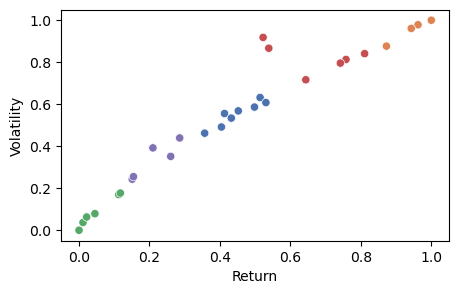

In [13]:
model = KMeans(n_clusters=visualizer.elbow_value_, random_state=0, n_init=10) 
fitted = model.fit(X)
labels = fitted.labels_

plt.figure(figsize=(5,3))
sns.scatterplot(X, x='Return', y='Volatility', hue=labels, palette='deep')
plt.legend([], frameon=False)
plt.show()

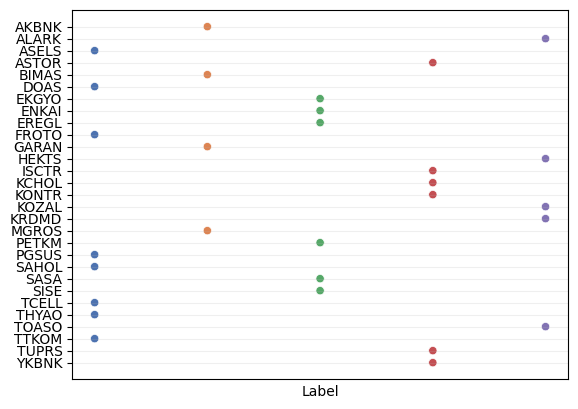

In [14]:
data['Label'] = labels
sns.scatterplot(data, x='Label', y=data.index, hue='Label', palette='deep')
plt.grid(axis='y', alpha=0.2)
plt.xticks([])
plt.ylabel(None)
plt.legend([], frameon=False)
plt.show()

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

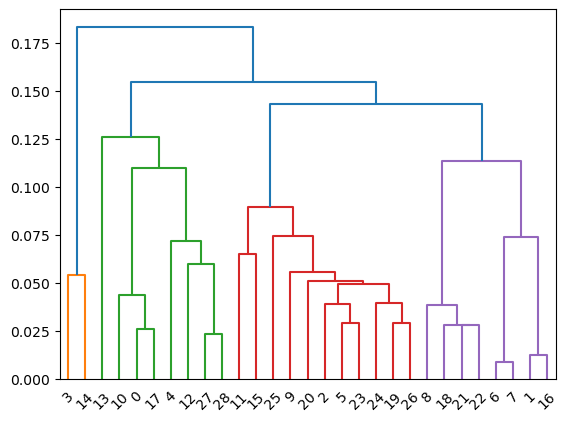

In [15]:
dendrogram(linkage(X, method='single'))
plt.show()

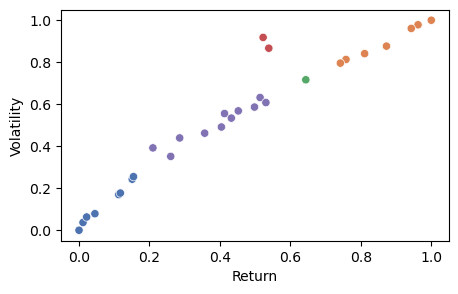

In [16]:
model = AgglomerativeClustering(n_clusters=5, linkage='single')
model.fit_predict(X)
labels = model.labels_

plt.figure(figsize=(5,3))
sns.scatterplot(X, x='Return', y='Volatility', hue=labels, palette='deep')
plt.legend([], frameon=False)
plt.show()

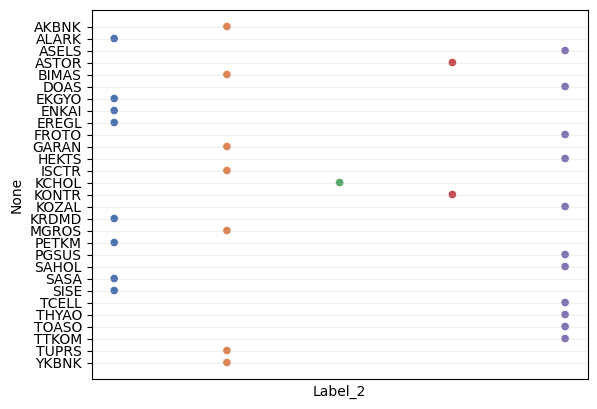

In [17]:
data['Label_2'] = labels
sns.scatterplot(data, x='Label_2', y=data.index, hue='Label_2', palette='deep')
plt.grid(axis='y', alpha=0.2)
plt.xticks([])
plt.legend([], frameon=False)
plt.show()

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>